### A rajouter/faire : 
- Données grèves métérologique et vacance

In [183]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

import torch.nn as nn
import torch.optim as optim
import tqdm
import numpy as np
import copy
from torch import nn, optim
import torch
from torch.utils.data import TensorDataset
from torch.nn.functional import l1_loss
from torch.optim.lr_scheduler import ReduceLROnPlateau


import numpy as np
import pandas as pd
import datetime as dt
from sqlalchemy import create_engine
import os 

import matplotlib.pyplot as plt
import seaborn as sns

### 

# CHARGEMENT DES DONNEES 

In [2]:
dialect = 'mysql+pymysql'
user = 'root'
password = os.getenv('mdp_mySQL')
host = 'localhost'
port = 3306
database_idf = 'SNCF_TGV_TER'

engine_url = f"{dialect}://{user}:{password}@{host}:{port}/{database_idf}"
engine = create_engine(engine_url)

In [3]:
df_disruption = pd.read_sql('disruptions_tgv_ter',engine)
df_disruption

,id_disruption,vehicle_id,train_type,id_stop,name_stop,lon,lat,disruption_start,disruption_end,arrival_delay,departure_delay,cause_delay,data_date
0,300d66cc-2614-4087-89d7-89abe997e2cf,SNCF:2024-03-18:12244:1187:LongDistanceTrain,TGV,stop_point:SNCF:87391003:LongDistanceTrain,Paris - Montparnasse - Hall 1 & 2,2.320510,48.8412,2024-03-18 18:46:00,2024-03-18 21:49:00,50.0,50.0,Défaut d'alimentation électrique,2024-03-18
1,300d66cc-2614-4087-89d7-89abe997e2cf,SNCF:2024-03-18:12244:1187:LongDistanceTrain,TGV,stop_point:SNCF:87393702:LongDistanceTrain,Massy TGV,2.261250,48.7258,2024-03-18 18:46:00,2024-03-18 21:49:00,50.0,50.0,Défaut d'alimentation électrique,2024-03-18
2,300d66cc-2614-4087-89d7-89abe997e2cf,SNCF:2024-03-18:12244:1187:LongDistanceTrain,TGV,stop_point:SNCF:87581009:LongDistanceTrain,Bordeaux Saint-Jean,-0.556697,44.8259,2024-03-18 18:46:00,2024-03-18 21:49:00,0.0,0.0,Défaut d'alimentation électrique,2024-03-18
3,dc1eeb61-3ef0-4bfe-b63b-8d52ec7577c5,SNCF:2024-03-18:12254:1187:LongDistanceTrain,TGV,stop_point:SNCF:87391003:LongDistanceTrain,Paris - Montparnasse - Hall 1 & 2,2.320510,48.8412,2024-03-18 10:46:00,2024-03-18 12:58:00,5.0,5.0,Régulation du trafic,2024-03-18
4,dc1eeb61-3ef0-4bfe-b63b-8d52ec7577c5,SNCF:2024-03-18:12254:1187:LongDistanceTrain,TGV,stop_point:SNCF:87581009:LongDistanceTrain,Bordeaux Saint-Jean,-0.556697,44.8259,2024-03-18 10:46:00,2024-03-18 12:58:00,0.0,0.0,Régulation du trafic,2024-03-18
...,...,...,...,...,...,...,...,...,...,...,...,...,...
58037,6c85e1b5-9a9b-4c43-b497-ee4d3a37513c,SNCF:2024-03-27:99209:1187:LongDistanceTrain,TGV,stop_point:SNCF:83002048:LongDistanceTrain,Oulx-Cesana-Claviere-Sestriere,6.831430,45.0388,2024-03-27 17:44:00,2024-03-27 23:25:00,15.0,15.0,Dérangement d'une installation en gare,2024-03-27
58038,6c85e1b5-9a9b-4c43-b497-ee4d3a37513c,SNCF:2024-03-27:99209:1187:LongDistanceTrain,TGV,stop_point:SNCF:83002220:LongDistanceTrain,Torino Porta Susa,7.666680,45.0741,2024-03-27 17:44:00,2024-03-27 23:25:00,15.0,15.0,Dérangement d'une installation en gare,2024-03-27
58039,6c85e1b5-9a9b-4c43-b497-ee4d3a37513c,SNCF:2024-03-27:99209:1187:LongDistanceTrain,TGV,stop_point:SNCF:83016451:LongDistanceTrain,Milano Porta Garibaldi,9.187690,45.4849,2024-03-27 17:44:00,2024-03-27 23:25:00,15.0,15.0,Dérangement d'une installation en gare,2024-03-27
58040,6c85e1b5-9a9b-4c43-b497-ee4d3a37513c,SNCF:2024-03-27:99209:1187:LongDistanceTrain,TGV,stop_point:SNCF:87741009:LongDistanceTrain,Chambéry - Challes-les-Eaux,5.919550,45.5713,2024-03-27 17:44:00,2024-03-27 23:25:00,15.0,15.0,Dérangement d'une installation en gare,2024-03-27


In [4]:
df_vehicle = pd.read_sql('vehicle_journeys_tgv_ter', engine)
df_vehicle['vehicle_id'] = df_vehicle['vehicle_id'].apply(lambda x: ':'.join(x.split(':')[1:]))
df_vehicle

,vehicle_id,route_id,time_begin,time_end,train_type,id_disruption,data_date
0,SNCF:2024-03-18:117752:1187:LongDistanceTrain,route:SNCF:FR:Line::B10C45A0-C32C-4232-85F2-4B...,05:00:00,07:19:00,Train grande vitesse,0f4e5f2c-a148-438f-b7cb-71b80199e8d4,2024-03-18
1,SNCF:2024-03-18:12244:1187:LongDistanceTrain,route:SNCF:CSR:421400,18:46:00,20:59:00,Train grande vitesse,300d66cc-2614-4087-89d7-89abe997e2cf,2024-03-18
2,SNCF:2024-03-18:12251:1187:LongDistanceTrain,route:SNCF:CSR:421400,07:04:00,09:14:00,Train grande vitesse,None,2024-03-18
3,SNCF:2024-03-18:12254:1187:LongDistanceTrain,route:SNCF:CSR:421400,10:46:00,12:53:00,Train grande vitesse,dc1eeb61-3ef0-4bfe-b63b-8d52ec7577c5,2024-03-18
4,SNCF:2024-03-18:12255:1187:LongDistanceTrain,route:SNCF:CSR:421400,11:04:00,13:14:00,Train grande vitesse,None,2024-03-18
...,...,...,...,...,...,...,...
82061,SNCF:2024-03-27:9890:1187:LongDistanceTrain,route:SNCF:CSR:005400,05:59:00,09:43:00,Train grande vitesse,None,2024-03-27
82062,SNCF:2024-03-27:9894:1187:LongDistanceTrain,route:SNCF:CSR:005400,17:01:00,21:01:00,Train grande vitesse,None,2024-03-27
82063,SNCF:2024-03-27:9896:1187:LongDistanceTrain,route:SNCF:CSR:071100,15:56:00,23:49:00,Train grande vitesse,None,2024-03-27
82064,SNCF:2024-03-27:9898:1187:LongDistanceTrain,route:SNCF:CSR:071200,06:31:00,14:15:00,Train grande vitesse,None,2024-03-27


In [5]:
df_lines = pd.read_sql_table('pt_lines_tgv_ter', engine)
df_lines

,route_id,route_name,train_type,network_name,opening_time,closing_time
0,route:SNCF:0018-80100537-87271007,Dortmund Hbf - Paris Nord,Train grande vitesse,Eurostar,05:18:00,12:21:00
1,route:SNCF:0018-80101840-87271007,Essen Hbf - Paris Nord,Train grande vitesse,Eurostar,07:35:00,22:14:00
2,route:SNCF:0018-80154583-87271007,Köln - Hauptbahnhof - Paris Nord,Train grande vitesse,Eurostar,05:21:00,23:14:00
3,route:SNCF:0018-84000588-87111849,Amsterdam Centraal - Marne-la-Vallée - Chessy,Train grande vitesse,Eurostar,06:47:00,11:05:00
4,route:SNCF:0018-84000588-87271007,Amsterdam Centraal - Paris Nord,Train grande vitesse,Eurostar,06:11:00,23:43:00
...,...,...,...,...,...,...
363,route:stop_area:SNCF:87113001_stop_area:SNCF:8...,Paris Est - Strasbourg,Train grande vitesse,additional service,None,None
364,route:stop_area:SNCF:87394007_stop_area:SNCF:8...,Chartres - Versailles Chantiers,Train grande vitesse,additional service,None,None
365,route:stop_area:SNCF:87411017_stop_area:SNCF:8...,Rouen Rive Droite - Paris Saint-Lazare,Train grande vitesse,additional service,None,None
366,route:stop_area:SNCF:87411017_stop_area:SNCF:8...,Rouen Rive Droite - Le Havre,Train grande vitesse,additional service,None,None


# 

# 

# PREPARATION DES DONNEES 

## Merge des tables 

Probleme que je ne comprend pas encore : il y a beaucoup plus de perturbation dans df_vehicle que dans df_disruption

In [6]:
df_merge_inter = pd.merge(df_disruption.drop(['data_date','train_type'],axis=1), df_vehicle, on=['vehicle_id','id_disruption'], how='left')
df_merge = pd.merge(df_merge_inter, df_lines.drop('train_type', axis=1), on='route_id', how='left')

In [7]:
df_merge_clean = df_merge.dropna(subset=['arrival_delay', 'departure_delay'])
df_merge_clean

,id_disruption,vehicle_id,id_stop,name_stop,lon,lat,disruption_start,disruption_end,arrival_delay,departure_delay,cause_delay,route_id,time_begin,time_end,train_type,data_date,route_name,network_name,opening_time,closing_time
0,300d66cc-2614-4087-89d7-89abe997e2cf,SNCF:2024-03-18:12244:1187:LongDistanceTrain,stop_point:SNCF:87391003:LongDistanceTrain,Paris - Montparnasse - Hall 1 & 2,2.320510,48.8412,2024-03-18 18:46:00,2024-03-18 21:49:00,50.0,50.0,Défaut d'alimentation électrique,route:SNCF:CSR:421400,18:46:00,20:59:00,Train grande vitesse,2024-03-18,Paris - Montparnasse - Hall 1 & 2 - Bordeaux S...,TGV INOUI,05:17:00,00:46:00
1,300d66cc-2614-4087-89d7-89abe997e2cf,SNCF:2024-03-18:12244:1187:LongDistanceTrain,stop_point:SNCF:87393702:LongDistanceTrain,Massy TGV,2.261250,48.7258,2024-03-18 18:46:00,2024-03-18 21:49:00,50.0,50.0,Défaut d'alimentation électrique,route:SNCF:CSR:421400,18:46:00,20:59:00,Train grande vitesse,2024-03-18,Paris - Montparnasse - Hall 1 & 2 - Bordeaux S...,TGV INOUI,05:17:00,00:46:00
2,300d66cc-2614-4087-89d7-89abe997e2cf,SNCF:2024-03-18:12244:1187:LongDistanceTrain,stop_point:SNCF:87581009:LongDistanceTrain,Bordeaux Saint-Jean,-0.556697,44.8259,2024-03-18 18:46:00,2024-03-18 21:49:00,0.0,0.0,Défaut d'alimentation électrique,route:SNCF:CSR:421400,18:46:00,20:59:00,Train grande vitesse,2024-03-18,Paris - Montparnasse - Hall 1 & 2 - Bordeaux S...,TGV INOUI,05:17:00,00:46:00
3,dc1eeb61-3ef0-4bfe-b63b-8d52ec7577c5,SNCF:2024-03-18:12254:1187:LongDistanceTrain,stop_point:SNCF:87391003:LongDistanceTrain,Paris - Montparnasse - Hall 1 & 2,2.320510,48.8412,2024-03-18 10:46:00,2024-03-18 12:58:00,5.0,5.0,Régulation du trafic,route:SNCF:CSR:421400,10:46:00,12:53:00,Train grande vitesse,2024-03-18,Paris - Montparnasse - Hall 1 & 2 - Bordeaux S...,TGV INOUI,05:17:00,00:46:00
4,dc1eeb61-3ef0-4bfe-b63b-8d52ec7577c5,SNCF:2024-03-18:12254:1187:LongDistanceTrain,stop_point:SNCF:87581009:LongDistanceTrain,Bordeaux Saint-Jean,-0.556697,44.8259,2024-03-18 10:46:00,2024-03-18 12:58:00,0.0,0.0,Régulation du trafic,route:SNCF:CSR:421400,10:46:00,12:53:00,Train grande vitesse,2024-03-18,Paris - Montparnasse - Hall 1 & 2 - Bordeaux S...,TGV INOUI,05:17:00,00:46:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58037,6c85e1b5-9a9b-4c43-b497-ee4d3a37513c,SNCF:2024-03-27:99209:1187:LongDistanceTrain,stop_point:SNCF:83002048:LongDistanceTrain,Oulx-Cesana-Claviere-Sestriere,6.831430,45.0388,2024-03-27 17:44:00,2024-03-27 23:25:00,15.0,15.0,Dérangement d'une installation en gare,route:SNCF:FR:Line::bd8f7fb5-658e-4960-a87d-de...,17:44:00,23:10:00,Train grande vitesse,2024-03-27,Paris - Vienne,NightJet,17:44:00,10:28:30
58038,6c85e1b5-9a9b-4c43-b497-ee4d3a37513c,SNCF:2024-03-27:99209:1187:LongDistanceTrain,stop_point:SNCF:83002220:LongDistanceTrain,Torino Porta Susa,7.666680,45.0741,2024-03-27 17:44:00,2024-03-27 23:25:00,15.0,15.0,Dérangement d'une installation en gare,route:SNCF:FR:Line::bd8f7fb5-658e-4960-a87d-de...,17:44:00,23:10:00,Train grande vitesse,2024-03-27,Paris - Vienne,NightJet,17:44:00,10:28:30
58039,6c85e1b5-9a9b-4c43-b497-ee4d3a37513c,SNCF:2024-03-27:99209:1187:LongDistanceTrain,stop_point:SNCF:83016451:LongDistanceTrain,Milano Porta Garibaldi,9.187690,45.4849,2024-03-27 17:44:00,2024-03-27 23:25:00,15.0,15.0,Dérangement d'une installation en gare,route:SNCF:FR:Line::bd8f7fb5-658e-4960-a87d-de...,17:44:00,23:10:00,Train grande vitesse,2024-03-27,Paris - Vienne,NightJet,17:44:00,10:28:30
58040,6c85e1b5-9a9b-4c43-b497-ee4d3a37513c,SNCF:2024-03-27:99209:1187:LongDistanceTrain,stop_point:SNCF:87741009:LongDistanceTrain,Chambéry - Challes-les-Eaux,5.919550,45.5713,2024-03-27 17:44:00,2024-03-27 23:25:00,15.0,15.0,Dérangement d'une installation en gare,route:SNCF:FR:Line::bd8f7fb5-658e-4960-a87d-de...,17:44:00,23:10:00,Train grande vitesse,2024-03-27,Paris - Vienne,NightJet,17:44:00,10:28:30


### Rajout des trajets non perturbé

In [8]:
df_vehicle_add = df_vehicle[df_vehicle['id_disruption'].isna()]
df_vehicle_add

,vehicle_id,route_id,time_begin,time_end,train_type,id_disruption,data_date
2,SNCF:2024-03-18:12251:1187:LongDistanceTrain,route:SNCF:CSR:421400,07:04:00,09:14:00,Train grande vitesse,None,2024-03-18
4,SNCF:2024-03-18:12255:1187:LongDistanceTrain,route:SNCF:CSR:421400,11:04:00,13:14:00,Train grande vitesse,None,2024-03-18
6,SNCF:2024-03-18:12259:1187:LongDistanceTrain,route:SNCF:CSR:421400,12:04:00,14:14:00,Train grande vitesse,None,2024-03-18
7,SNCF:2024-03-18:12260:1187:LongDistanceTrain,route:SNCF:CSR:421400,14:46:00,17:03:00,Train grande vitesse,None,2024-03-18
9,SNCF:2024-03-18:12265:1187:LongDistanceTrain,route:SNCF:CSR:421400,13:58:00,16:14:00,Train grande vitesse,None,2024-03-18
...,...,...,...,...,...,...,...
82060,SNCF:2024-03-27:9886:1187:LongDistanceTrain,route:SNCF:CSR:003200,05:59:00,11:01:00,Train grande vitesse,None,2024-03-27
82061,SNCF:2024-03-27:9890:1187:LongDistanceTrain,route:SNCF:CSR:005400,05:59:00,09:43:00,Train grande vitesse,None,2024-03-27
82062,SNCF:2024-03-27:9894:1187:LongDistanceTrain,route:SNCF:CSR:005400,17:01:00,21:01:00,Train grande vitesse,None,2024-03-27
82063,SNCF:2024-03-27:9896:1187:LongDistanceTrain,route:SNCF:CSR:071100,15:56:00,23:49:00,Train grande vitesse,None,2024-03-27


In [9]:
#df_vehicle_add_merge  = pd.merge(df_vehicle_add,df_lines.drop('train_type', axis=1), on='route_id', how='left')
#df_vehicle_add_merge

In [10]:
df_vehicle_add.info()

<class 'pandas.core.frame.DataFrame'>
Index: 71070 entries, 2 to 82064
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   vehicle_id     71070 non-null  object        
 1   route_id       71070 non-null  object        
 2   time_begin     71070 non-null  object        
 3   time_end       71070 non-null  object        
 4   train_type     71070 non-null  object        
 5   id_disruption  0 non-null      object        
 6   data_date      71070 non-null  datetime64[ns]
dtypes: datetime64[ns](1), object(6)
memory usage: 4.3+ MB


In [11]:
df_final = pd.concat([df_merge_inter, df_vehicle_add], ignore_index=True)
df_final

,id_disruption,vehicle_id,id_stop,name_stop,lon,lat,disruption_start,disruption_end,arrival_delay,departure_delay,cause_delay,route_id,time_begin,time_end,train_type,data_date
0,300d66cc-2614-4087-89d7-89abe997e2cf,SNCF:2024-03-18:12244:1187:LongDistanceTrain,stop_point:SNCF:87391003:LongDistanceTrain,Paris - Montparnasse - Hall 1 & 2,2.320510,48.8412,2024-03-18 18:46:00,2024-03-18 21:49:00,50.0,50.0,Défaut d'alimentation électrique,route:SNCF:CSR:421400,18:46:00,20:59:00,Train grande vitesse,2024-03-18
1,300d66cc-2614-4087-89d7-89abe997e2cf,SNCF:2024-03-18:12244:1187:LongDistanceTrain,stop_point:SNCF:87393702:LongDistanceTrain,Massy TGV,2.261250,48.7258,2024-03-18 18:46:00,2024-03-18 21:49:00,50.0,50.0,Défaut d'alimentation électrique,route:SNCF:CSR:421400,18:46:00,20:59:00,Train grande vitesse,2024-03-18
2,300d66cc-2614-4087-89d7-89abe997e2cf,SNCF:2024-03-18:12244:1187:LongDistanceTrain,stop_point:SNCF:87581009:LongDistanceTrain,Bordeaux Saint-Jean,-0.556697,44.8259,2024-03-18 18:46:00,2024-03-18 21:49:00,0.0,0.0,Défaut d'alimentation électrique,route:SNCF:CSR:421400,18:46:00,20:59:00,Train grande vitesse,2024-03-18
3,dc1eeb61-3ef0-4bfe-b63b-8d52ec7577c5,SNCF:2024-03-18:12254:1187:LongDistanceTrain,stop_point:SNCF:87391003:LongDistanceTrain,Paris - Montparnasse - Hall 1 & 2,2.320510,48.8412,2024-03-18 10:46:00,2024-03-18 12:58:00,5.0,5.0,Régulation du trafic,route:SNCF:CSR:421400,10:46:00,12:53:00,Train grande vitesse,2024-03-18
4,dc1eeb61-3ef0-4bfe-b63b-8d52ec7577c5,SNCF:2024-03-18:12254:1187:LongDistanceTrain,stop_point:SNCF:87581009:LongDistanceTrain,Bordeaux Saint-Jean,-0.556697,44.8259,2024-03-18 10:46:00,2024-03-18 12:58:00,0.0,0.0,Régulation du trafic,route:SNCF:CSR:421400,10:46:00,12:53:00,Train grande vitesse,2024-03-18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129107,None,SNCF:2024-03-27:9886:1187:LongDistanceTrain,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,route:SNCF:CSR:003200,05:59:00,11:01:00,Train grande vitesse,2024-03-27
129108,None,SNCF:2024-03-27:9890:1187:LongDistanceTrain,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,route:SNCF:CSR:005400,05:59:00,09:43:00,Train grande vitesse,2024-03-27
129109,None,SNCF:2024-03-27:9894:1187:LongDistanceTrain,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,route:SNCF:CSR:005400,17:01:00,21:01:00,Train grande vitesse,2024-03-27
129110,None,SNCF:2024-03-27:9896:1187:LongDistanceTrain,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,route:SNCF:CSR:071100,15:56:00,23:49:00,Train grande vitesse,2024-03-27


## Création de variables

In [12]:
df_final['disrupted'] = np.where(df_final['id_disruption'].isna(), 0, 1)

In [13]:
df_final['week_day'] = df_final['data_date'].dt.weekday

In [14]:
df_final_v2 = df_final[[#'id_disruption', 
        #'vehicle_id', 
        'id_stop', 
        #'name_stop', 
        #'lon', 
        #'lat',
        'disruption_start',
        'disruption_end', 
        'arrival_delay',
        'departure_delay', 
        'cause_delay',
        'route_id',
        'time_begin',
        'time_end',
        'train_type',
        #'data_date',
        'disrupted',
        'week_day']]

In [15]:
# Création de valeurs binaires pour chaque type de train et jour de la semaine
df_final_v2 = pd.get_dummies(df_final_v2, columns=['train_type','week_day'])

In [16]:
# On crée des tranches d'heures de 30 minutes allant de 5h00 à 24h00
tranches = list(range(5*60, 24*60 + 30, 30))

def train_dans_tranche(depart, arrivee, tranche_debut, tranche_fin):
    return not (arrivee <= tranche_debut or depart >= tranche_fin)

for i in range(len(tranches)-1):
    debut_heure = tranches[i] // 60
    debut_minute = tranches[i] % 60
    fin_heure = tranches[i + 1] // 60
    fin_minute = tranches[i + 1] % 60

    tranche_nom = f'{debut_heure:02d}h{debut_minute:02d}-{fin_heure:02d}h{fin_minute:02d}'
    df_final_v2[tranche_nom] = df_final_v2.apply(lambda x: train_dans_tranche(x['time_begin'].hour*60 + x['time_begin'].minute, x['time_end'].hour*60 + x['time_end'].minute, tranches[i], tranches[i+1]), axis=1)


In [17]:
# On remplace les trajets et les gares par leur fréquence respective
route_freq = df_final_v2['route_id'].value_counts() / len(df_final_v2)
df_final_v2['route_freq'] = df_final_v2['route_id'].map(route_freq)

stop_freq = df_final_v2['id_stop'].value_counts() / len(df_final_v2[~df_final_v2['id_stop'].isna()])
df_final_v2['stop_freq'] = df_final_v2['id_stop'].map(stop_freq)

In [18]:
# Attribution d'un nombre à chaque cause de perturbation
df_final_v2['cause_delay_label'] = df_final_v2['cause_delay']
df_final_v2['cause_delay'] = pd.factorize(df_final_v2['cause_delay'])[0]

In [19]:
# Regroupement des causes de perturbation selon leurs types 
def regrouper_causes(cause):
    if cause in ["Défaut d'alimentation électrique", 'Défaillance de matériel', 'Panne de signalisation', "Panne d'un passage à niveau", "Panne d'un aiguillage", "Dérangement d'un équipement technique ou informatique", 'Incident technique sur la voie', 'Choc nécessitant une vérification technique sur le train', 'Incident technique sur le car']:
        return 'Problèmes Techniques et Défaillances'
    elif cause in ["Régulation du trafic", "Réutilisation d'un train", 'Travaux sur les voies', 'Difficultés lors de la préparation du train', 'Conditions de départ non réunies', 'Prise en charge de clients en correspondance', 'Saturation des voies en gare', 'Modification de matériel', 'Mise à quai tardive en gare origine', 'Confirmation tardive de la voie', "Erreur d'itinéraire"]:
        return 'Problèmes Logistiques et Opérationnels'
    elif cause in ["Présence d'individus sur les voies", 'Obstacle sur la voie', "Présence d'un bagage abandonné", 'Incident de circulation', 'Accident à un passage à niveau', 'Accident de personne', "Présence d'animaux sur la voie", 'Acte de vandalisme', 'Affluence de voyageurs entraînant un arrêt prolongé', 'Conditions météorologiques', 'Incendie aux abords de la voie', 'Incident sur un train de marchandises', "Ralentissement par manque d'adhérence"]:
        return 'Incidents Externes'
    elif cause in ["Grève SNCF inopinée", "Intervention des forces de l'ordre", 'Assistance à un voyageur malade à bord', "Déclenchement du signal d'alarme", 'Assistance à un voyageur']:
        return 'Interventions et Sécurité'
    else:
        return 'Autres / Non Spécifié'

df_final_v2['cause_delay_grouped'] = df_final_v2['cause_delay_label'].apply(regrouper_causes)

df_final_v2['cause_delay_grouped_label'] = df_final_v2['cause_delay_grouped']
df_final_v2['cause_delay_grouped'] = pd.factorize(df_final_v2['cause_delay_grouped'])[0]

In [20]:
df_final_v2 = df_final_v2.drop(['time_begin', 'time_end','route_id', 'id_stop'], axis=1)

In [21]:
df_final_v2

,disruption_start,disruption_end,arrival_delay,departure_delay,cause_delay,disrupted,train_type_TER / Intercités,train_type_Train grande vitesse,week_day_0,week_day_1,...,21h30-22h00,22h00-22h30,22h30-23h00,23h00-23h30,23h30-24h00,route_freq,stop_freq,cause_delay_label,cause_delay_grouped,cause_delay_grouped_label
0,2024-03-18 18:46:00,2024-03-18 21:49:00,50.0,50.0,0,1,False,True,True,False,...,False,False,False,False,False,0.003478,0.006805,Défaut d'alimentation électrique,0,Problèmes Techniques et Défaillances
1,2024-03-18 18:46:00,2024-03-18 21:49:00,50.0,50.0,0,1,False,True,True,False,...,False,False,False,False,False,0.003478,0.001275,Défaut d'alimentation électrique,0,Problèmes Techniques et Défaillances
2,2024-03-18 18:46:00,2024-03-18 21:49:00,0.0,0.0,0,1,False,True,True,False,...,False,False,False,False,False,0.003478,0.004049,Défaut d'alimentation électrique,0,Problèmes Techniques et Défaillances
3,2024-03-18 10:46:00,2024-03-18 12:58:00,5.0,5.0,1,1,False,True,True,False,...,False,False,False,False,False,0.003478,0.006805,Régulation du trafic,1,Problèmes Logistiques et Opérationnels
4,2024-03-18 10:46:00,2024-03-18 12:58:00,0.0,0.0,1,1,False,True,True,False,...,False,False,False,False,False,0.003478,0.004049,Régulation du trafic,1,Problèmes Logistiques et Opérationnels
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129107,NaT,NaT,NaN,NaN,-1,0,False,True,False,False,...,False,False,False,False,False,0.000550,NaN,NaN,4,Autres / Non Spécifié
129108,NaT,NaT,NaN,NaN,-1,0,False,True,False,False,...,False,False,False,False,False,0.000441,NaN,NaN,4,Autres / Non Spécifié
129109,NaT,NaT,NaN,NaN,-1,0,False,True,False,False,...,False,False,False,False,False,0.000441,NaN,NaN,4,Autres / Non Spécifié
129110,NaT,NaT,NaN,NaN,-1,0,False,True,False,False,...,True,True,True,True,True,0.001665,NaN,NaN,4,Autres / Non Spécifié


#
#

# PREDIRE SI LE TRAJET VA ETRE PERTURBE OU NON

## 

### RANDOM FOREST (CLASSIFICATION)

In [23]:
df_rf_cla = df_final_v2.drop(['stop_freq',
                'disruption_start',
                'disruption_end',
                'arrival_delay',
                'departure_delay',
                'cause_delay',
                'train_type_Train grande vitesse',
                'train_type_TER / Intercités',
                'cause_delay_label',
                'cause_delay_grouped_label',
                'cause_delay_grouped'],
                             axis=1)

In [24]:
df_rf_cla.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129112 entries, 0 to 129111
Data columns (total 47 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   disrupted    129112 non-null  int32  
 1   week_day_0   129112 non-null  bool   
 2   week_day_1   129112 non-null  bool   
 3   week_day_2   129112 non-null  bool   
 4   week_day_3   129112 non-null  bool   
 5   week_day_4   129112 non-null  bool   
 6   week_day_5   129112 non-null  bool   
 7   week_day_6   129112 non-null  bool   
 8   05h00-05h30  129112 non-null  bool   
 9   05h30-06h00  129112 non-null  bool   
 10  06h00-06h30  129112 non-null  bool   
 11  06h30-07h00  129112 non-null  bool   
 12  07h00-07h30  129112 non-null  bool   
 13  07h30-08h00  129112 non-null  bool   
 14  08h00-08h30  129112 non-null  bool   
 15  08h30-09h00  129112 non-null  bool   
 16  09h00-09h30  129112 non-null  bool   
 17  09h30-10h00  129112 non-null  bool   
 18  10h00-10h30  129112 non-

In [25]:
X_rf_cla = df_rf_cla.drop('disrupted', axis=1)
y_rf_cla = df_rf_cla['disrupted']

X_train_rf_cla, X_test_rf_cla, y_train_rf_cla, y_test_rf_cla = train_test_split(X_rf_cla, y_rf_cla, test_size=0.2, random_state=24)

In [26]:
rf = RandomForestClassifier(class_weight='balanced', random_state=24)
rf.fit(X_train_rf_cla, y_train_rf_cla)

RandomForestClassifier(class_weight='balanced', random_state=24)

In [27]:
# Prédictions
predictions = rf.predict(X_test_rf_cla)

# Évaluation
print(classification_report(y_test_rf_cla, predictions))
print("ROC AUC score:", roc_auc_score(y_test_rf_cla, predictions))

              precision    recall  f1-score   support

           0       0.99      0.88      0.93     14208
           1       0.87      0.99      0.93     11615

    accuracy                           0.93     25823
   macro avg       0.93      0.94      0.93     25823
weighted avg       0.94      0.93      0.93     25823

ROC AUC score: 0.9353757942994653


###  Ajustements des paramètres

In [ ]:
param_grid = {
    'n_estimators': [200,300,400],  
    'max_depth': [None, 10,30,50],  
}

grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='roc_auc')
grid_search.fit(X_train_rf_cla, y_train_rf_cla)

print("Meilleurs paramètres:", grid_search.best_params_)

In [ ]:
rf_best = RandomForestClassifier(**grid_search.best_params_,random_state=10)
rf_best.fit(X_train_rf_cla, y_train_rf_cla)

In [ ]:
# Prédictions
predictions_best = rf_best.predict(X_test_rf_cla)

# Évaluation
print(classification_report(y_test_rf_cla, predictions_best))
print("ROC AUC score:", roc_auc_score(y_test_rf_cla, predictions_best))

In [ ]:
importances = rf_best.feature_importances_

features = X_train_rf_cla.columns
importance_scores = sorted(list(zip(features, importances)), key=lambda x: x[1], reverse=True)

for feature, importance in importance_scores:
    print(f"{feature}: {importance}")

# 

# 

# PREDIRE LE TYPE DE PERTURBATION D'UN TRAJET PERTURBE

## 

### RANDOM FOREST (CLASSIFICATION)

In [35]:
df_rf_cla2 = df_final_v2[df_final_v2['disrupted']==1] 
df_rf_cla2 = df_rf_cla2[df_rf_cla2['cause_delay']>=0] 

df_rf_cla2 = df_rf_cla2.drop(['disruption_start', 
                        'disruption_end', 
                        'arrival_delay',
                        'departure_delay', 
                        'disrupted',
                        'train_type_TER / Intercités',
                        'train_type_Train grande vitesse',
                        'stop_freq',
                        'cause_delay_label',
                        'cause_delay_grouped_label',
                        'cause_delay'],
                        axis=1)

In [36]:
df_rf_cla2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 54401 entries, 0 to 58041
Data columns (total 47 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   week_day_0           54401 non-null  bool   
 1   week_day_1           54401 non-null  bool   
 2   week_day_2           54401 non-null  bool   
 3   week_day_3           54401 non-null  bool   
 4   week_day_4           54401 non-null  bool   
 5   week_day_5           54401 non-null  bool   
 6   week_day_6           54401 non-null  bool   
 7   05h00-05h30          54401 non-null  bool   
 8   05h30-06h00          54401 non-null  bool   
 9   06h00-06h30          54401 non-null  bool   
 10  06h30-07h00          54401 non-null  bool   
 11  07h00-07h30          54401 non-null  bool   
 12  07h30-08h00          54401 non-null  bool   
 13  08h00-08h30          54401 non-null  bool   
 14  08h30-09h00          54401 non-null  bool   
 15  09h00-09h30          54401 non-null  bool

In [37]:
X_rf_cla2 = df_rf_cla2.drop('cause_delay_grouped', axis=1)
y_rf_cla2 = df_rf_cla2['cause_delay_grouped']

X_train_rf_cla2, X_test_rf_cla2, y_train_rf_cla2, y_test_rf_cla2 = train_test_split(X_rf_cla2, y_rf_cla2, test_size=0.2, random_state=24)

In [38]:
rf = RandomForestClassifier(random_state=24)
rf.fit(X_train_rf_cla2, y_train_rf_cla2)

RandomForestClassifier(random_state=24)

In [39]:
# Prédiction
predictions = rf.predict(X_test_rf_cla2)

# Évaluation des prédictions
print(classification_report(y_test_rf_cla2, predictions))

              precision    recall  f1-score   support

           0       0.94      0.94      0.94      1553
           1       0.97      0.97      0.97      7389
           2       0.96      0.96      0.96       183
           3       0.93      0.90      0.92      1234
           4       0.90      0.94      0.92       522

    accuracy                           0.96     10881
   macro avg       0.94      0.94      0.94     10881
weighted avg       0.96      0.96      0.96     10881



### Ajustements des paramètres

In [ ]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='roc_auc')
grid_search.fit(X_train_rf_cla2, y_train_rf_cla2)

print("Meilleurs paramètres:", grid_search.best_params_)

In [ ]:
rf_best = RandomForestClassifier(**grid_search.best_params_,random_state=10)
rf_best.fit(X_train_rf_cla2, y_train_rf_cla2)

In [ ]:
# Prédictions
predictions_best = rf_best.predict(X_test_rf_cla2)

# Évaluation
print(classification_report(y_test_rf_cla2, predictions_best))
print("ROC AUC score:", roc_auc_score(y_test_rf_cla2, predictions_best))

In [ ]:
importances = rf_best.feature_importances_

features = X_train_rf_cla2.columns
importance_scores = sorted(list(zip(features, importances)), key=lambda x: x[1], reverse=True)

for feature, importance in importance_scores:
    print(f"{feature}: {importance}")

# 

# 

# PREDIRE LE RETARD AU DEPART D'UN TRAJET PERTURBE (en minutes)

## 

### RANDOM FOREST (REGRESSION)

In [22]:
df_rf_reg = df_final_v2[df_final_v2['disrupted']==1] 
df_rf_reg = df_rf_reg[df_rf_reg['cause_delay']>=0] 

df_rf_reg = df_rf_reg.drop(['disruption_start', 
                        'disruption_end', 
                        'arrival_delay', 
                        'disrupted',
                        'cause_delay_label',
                        'cause_delay_grouped_label',
                        'cause_delay', 
                        'train_type_Train grande vitesse',
                        'train_type_TER / Intercités'],
                        axis=1)

In [23]:
df_rf_reg = df_rf_reg[df_rf_reg['departure_delay'].notna()]
df_rf_reg = df_rf_reg[df_rf_reg['departure_delay']>=0]

In [24]:
df_rf_reg = pd.get_dummies(df_rf_reg, columns=['cause_delay_grouped'])

In [25]:
df_rf_reg.info()

<class 'pandas.core.frame.DataFrame'>
Index: 52319 entries, 0 to 58041
Data columns (total 53 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   departure_delay        52319 non-null  float64
 1   week_day_0             52319 non-null  bool   
 2   week_day_1             52319 non-null  bool   
 3   week_day_2             52319 non-null  bool   
 4   week_day_3             52319 non-null  bool   
 5   week_day_4             52319 non-null  bool   
 6   week_day_5             52319 non-null  bool   
 7   week_day_6             52319 non-null  bool   
 8   05h00-05h30            52319 non-null  bool   
 9   05h30-06h00            52319 non-null  bool   
 10  06h00-06h30            52319 non-null  bool   
 11  06h30-07h00            52319 non-null  bool   
 12  07h00-07h30            52319 non-null  bool   
 13  07h30-08h00            52319 non-null  bool   
 14  08h00-08h30            52319 non-null  bool   
 15  08h30-0

In [198]:
X_rf_reg = df_rf_reg.drop('departure_delay', axis=1)
y_rf_reg = df_rf_reg['departure_delay']
X_train_rf_reg, X_test_rf_reg, y_train_rf_reg, y_test_rf_reg = train_test_split(X_rf_reg, y_rf_reg, test_size=0.2, random_state=24)

In [199]:
rf = RandomForestRegressor(random_state=24)
rf.fit(X_train_rf_reg, y_train_rf_reg)

RandomForestRegressor(random_state=24)

In [200]:
# Prédictions de retard en minutes
predictions_reg = rf.predict(X_test_rf_reg)

# Évaluation
print("MSE:", mean_squared_error(y_test_rf_reg, predictions_reg))
print("MAE:", mean_absolute_error(y_test_rf_reg, predictions_reg))
print("R² score:", r2_score(y_test_rf_reg, predictions_reg))

MSE: 83.94619499082769
MAE: 3.250360648725284
R² score: 0.7531585433542083


In [201]:
importances = rf.feature_importances_

features = X_train_rf_reg.columns
importance_scores = sorted(list(zip(features, importances)), key=lambda x: x[1], reverse=True)

for feature, importance in importance_scores:
    print(f"{feature}: {importance}")

route_freq: 0.26638061991847045
stop_freq: 0.13021173477712344
week_day_4: 0.07100348859130183
cause_delay_grouped_3: 0.05729739828122125
week_day_1: 0.02685806081002509
week_day_0: 0.024833861398175665
week_day_2: 0.021642901627192113
18h00-18h30: 0.017973372422175934
cause_delay_grouped_0: 0.01580422996626127
18h30-19h00: 0.014203081533130922
13h30-14h00: 0.013754985926440368
09h30-10h00: 0.013549266998575312
10h00-10h30: 0.0135237298506171
19h00-19h30: 0.013368834569711942
20h00-20h30: 0.012191840442253445
20h30-21h00: 0.011985601821164336
08h30-09h00: 0.011932158920678008
12h00-12h30: 0.011843473858749808
21h00-21h30: 0.011542239017090892
week_day_3: 0.011119413781642227
19h30-20h00: 0.011025444864462924
16h30-17h00: 0.010979565581009395
08h00-08h30: 0.010897578567067082
11h00-11h30: 0.010480949794608568
17h30-18h00: 0.010136247750253465
week_day_5: 0.010130796704376702
14h30-15h00: 0.010122037905158912
07h00-07h30: 0.009827569643148024
09h00-09h30: 0.009655399086527556
17h00-17h30

## 

### RESAUX DE NEURONE ENTIEREMENT CONNECTE

#### Préparation des données


In [ ]:
df_nn = df_rf_reg

In [166]:
scaler = StandardScaler()

df_nn[['route_freq', 'stop_freq']] = scaler.fit_transform(df_nn[['route_freq', 'stop_freq']])

In [167]:
X_nn = df_rn.drop('departure_delay', axis=1)
y_nn = df_rn['departure_delay']

X_nn = np.asarray(X_nn, dtype=np.float32)
y_nn = np.asarray(y_nn, dtype=np.float32)

X_train_nn, X_test_nn, y_train_nn, y_test_nn = train_test_split(X_nn, y_nn, test_size=0.2, random_state=24)

In [168]:
X_train_nn = torch.tensor(X_train_nn, dtype=torch.float32)
y_train_nn = torch.tensor(y_train_nn, dtype=torch.float32).reshape(-1, 1)

X_test_nn = torch.tensor(X_test_nn, dtype=torch.float32)
y_test_nn = torch.tensor(y_test_nn, dtype=torch.float32).reshape(-1, 1)

#### Modèle

In [174]:
model = nn.Sequential(
    nn.Linear(52, 512), 
    nn.ReLU(),
    nn.BatchNorm1d(512),
    nn.Dropout(0.25), 
    
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.BatchNorm1d(256),
    nn.Dropout(0.25),
    
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.BatchNorm1d(128),
    nn.Dropout(0.2),
    
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.BatchNorm1d(64),
    nn.Dropout(0.15),
    
    nn.Linear(64, 1)
)

optimizer = optim.Adam(model.parameters(), lr=0.0005) 
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5, min_lr=1e-6, verbose=True)

loss_fn = nn.MSELoss()
l1_loss = nn.L1Loss()

def r2_score(outputs, labels):
    total_variance = torch.var(labels, unbiased=False)
    explained_variance = torch.var(labels - outputs, unbiased=False)
    r2 = 1 - explained_variance / total_variance
    return r2

n_epochs = 100
batch_size = 64
best_val_loss = np.inf
best_val_r2 = -np.inf 
best_model_wts = copy.deepcopy(model.state_dict())
patience, trials = 10, 0
history = []

for epoch in range(n_epochs):
    model.train()
    running_loss = 0.0
    
    permutation = torch.randperm(X_train_nn.size()[0])
    for i in range(0, X_train_nn.size()[0], batch_size):
        indices = permutation[i:i+batch_size]
        batch_x, batch_y = X_train_nn[indices], y_train_nn[indices]

        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = loss_fn(outputs, batch_y)
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * batch_x.size(0)
    
    epoch_loss = running_loss / len(X_train_nn)
    history.append(epoch_loss)
    
    model.eval()
    with torch.no_grad():
        y_pred = model(X_test_nn)
        mse_value = loss_fn(y_pred, y_test_nn).item()
        mae_value = l1_loss(y_pred, y_test_nn).item()
        val_r2 = r2_score(y_pred, y_test_nn).item()

    scheduler.step(mse_value)

    if mse_value < best_val_loss or val_r2 > best_val_r2:
        if mse_value < best_val_loss:
            best_val_loss = mse_value
        if val_r2 > best_val_r2:
            best_val_r2 = val_r2
        best_model_wts = copy.deepcopy(model.state_dict())
        trials = 0
    else:
        trials += 1
        if trials >= patience:
            print("Early stopping triggered")
            break
    
    print(f'Epoch {epoch+1}/{n_epochs}, Loss: {epoch_loss:.4f}, Val MSE: {mse_value:.4f}, Val R²: {val_r2:.4f}, Val MAE: {mae_value:.4f}')

model.load_state_dict(best_model_wts)

Epoch 1/100, Loss: 387.1122, Val MSE: 294.8530, Val R²: 0.2407, Val MAE: 9.1803
Epoch 2/100, Loss: 261.5802, Val MSE: 230.9119, Val R²: 0.3211, Val MAE: 8.5638
Epoch 3/100, Loss: 231.8678, Val MSE: 212.6569, Val R²: 0.3750, Val MAE: 8.3993
Epoch 4/100, Loss: 220.4945, Val MSE: 200.0976, Val R²: 0.4116, Val MAE: 8.0334
Epoch 5/100, Loss: 206.5262, Val MSE: 199.9398, Val R²: 0.4135, Val MAE: 8.0539
Epoch 6/100, Loss: 195.8048, Val MSE: 193.9311, Val R²: 0.4298, Val MAE: 7.8063
Epoch 7/100, Loss: 191.0145, Val MSE: 179.0552, Val R²: 0.4735, Val MAE: 7.4258
Epoch 8/100, Loss: 185.0494, Val MSE: 180.2516, Val R²: 0.4704, Val MAE: 7.2364
Epoch 9/100, Loss: 176.8890, Val MSE: 175.7644, Val R²: 0.4838, Val MAE: 7.1092
Epoch 10/100, Loss: 173.5063, Val MSE: 171.9080, Val R²: 0.4950, Val MAE: 7.0893
Epoch 11/100, Loss: 171.1727, Val MSE: 168.1349, Val R²: 0.5075, Val MAE: 6.8909
Epoch 12/100, Loss: 165.3785, Val MSE: 160.0210, Val R²: 0.5303, Val MAE: 6.7927
Epoch 13/100, Loss: 166.2523, Val MSE

<All keys matched successfully>

Performance du meilleur modèle sur l'ensemble de test : MSE: 115.1581, R²: 0.6615


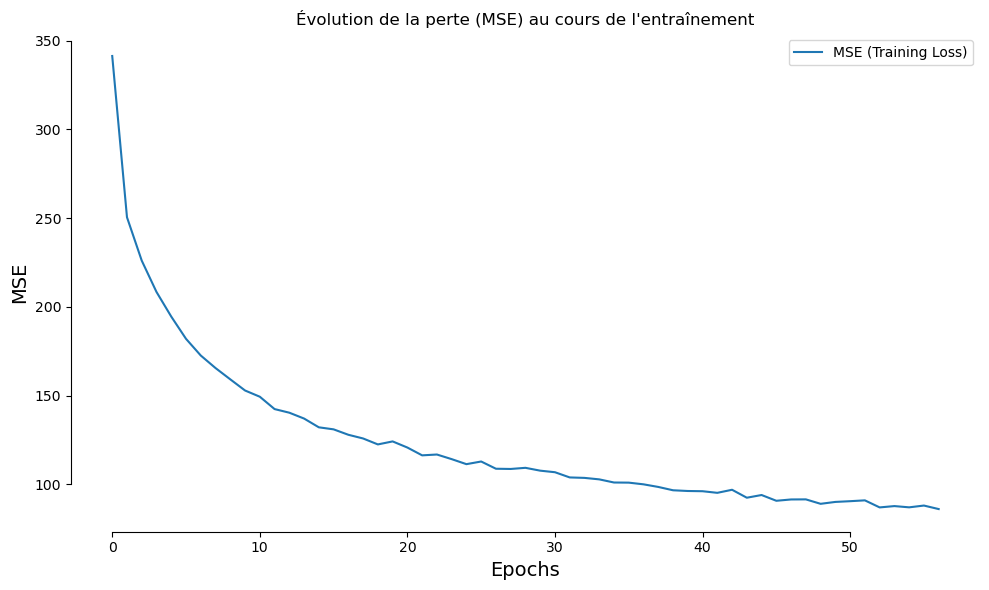

In [203]:
print(f"Performance du meilleur modèle sur l'ensemble de test : MSE: {best_val_loss:.4f}, R²: {best_val_r2:.4f}")

plt.figure(figsize=(10, 6))
plt.plot(history, label='MSE (Training Loss)')
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('MSE', fontsize=14)
plt.title('Évolution de la perte (MSE) au cours de l\'entraînement')
plt.legend()
sns.despine(offset=0, trim=True)
plt.tight_layout()
plt.show()

# 

# PREDIRE LE RETARD A L'ARRIVEE D'UN TRAJET PERTURBE (en minutes)

## 

### RANDOM FOREST (REGRESSION)

In [40]:
df_rf_reg2 = df_final_v2[df_final_v2['disrupted']==1] 
df_rf_reg2 = df_rf_reg2[df_rf_reg2['cause_delay']>=0] 

df_rf_reg2 = df_rf_reg2.drop(['disruption_start', 
                        'disruption_end', 
                        'departure_delay', 
                        'disrupted',
                        'cause_delay_label',
                        'cause_delay_grouped_label',
                        'cause_delay', 
                        'train_type_Train grande vitesse',
                        'train_type_TER / Intercités'],
                        axis=1)

In [41]:
df_rf_reg2 = df_rf_reg2[df_rf_reg2['arrival_delay'].notna()]
df_rf_reg2 = df_rf_reg2[df_rf_reg2['arrival_delay']>=0]

In [42]:
df_rf_reg2 = pd.get_dummies(df_rf_reg2, columns=['cause_delay_grouped'])

In [43]:
df_rf_reg2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 52330 entries, 0 to 58041
Data columns (total 53 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   arrival_delay          52330 non-null  float64
 1   week_day_0             52330 non-null  bool   
 2   week_day_1             52330 non-null  bool   
 3   week_day_2             52330 non-null  bool   
 4   week_day_3             52330 non-null  bool   
 5   week_day_4             52330 non-null  bool   
 6   week_day_5             52330 non-null  bool   
 7   week_day_6             52330 non-null  bool   
 8   05h00-05h30            52330 non-null  bool   
 9   05h30-06h00            52330 non-null  bool   
 10  06h00-06h30            52330 non-null  bool   
 11  06h30-07h00            52330 non-null  bool   
 12  07h00-07h30            52330 non-null  bool   
 13  07h30-08h00            52330 non-null  bool   
 14  08h00-08h30            52330 non-null  bool   
 15  08h30-0

In [44]:
X_rf_reg2 = df_rf_reg2.drop('arrival_delay', axis=1)
y_rf_reg2 = df_rf_reg2['arrival_delay']
X_train_rf_reg2, X_test_rf_reg2, y_train_rf_reg2, y_test_rf_reg2 = train_test_split(X_rf_reg2, y_rf_reg2, test_size=0.2, random_state=24)

In [45]:
rf = RandomForestRegressor(random_state=24)
rf.fit(X_train_rf_reg2, y_train_rf_reg2)

RandomForestRegressor(random_state=24)

In [46]:
# Prédictions de retard en minutes
predictions_reg2 = rf.predict(X_test_rf_reg2)

# Évaluation
print("MSE:", mean_squared_error(y_test_rf_reg2, predictions_reg2))
print("MAE:", mean_absolute_error(y_test_rf_reg2, predictions_reg2))
print("R² score:", r2_score(y_test_rf_reg2, predictions_reg2))

MSE: 82.40741701186558
MAE: 3.191935017589141
R² score: 0.7384011770251263


In [47]:
importances = rf.feature_importances_

features = X_train_rf_reg2.columns
importance_scores = sorted(list(zip(features, importances)), key=lambda x: x[1], reverse=True)

for feature, importance in importance_scores:
    print(f"{feature}: {importance}")

route_freq: 0.2699372634302675
stop_freq: 0.13495078433276292
week_day_4: 0.07270980986999842
cause_delay_grouped_3: 0.058600958969941185
week_day_1: 0.026153624982168663
week_day_0: 0.02353426874796309
18h00-18h30: 0.02085748833062452
week_day_2: 0.02058026438054916
18h30-19h00: 0.015016972905486582
10h00-10h30: 0.014833136470447596
cause_delay_grouped_0: 0.014342002025490835
19h00-19h30: 0.014166941430699943
16h30-17h00: 0.013482273478074817
19h30-20h00: 0.013133331785618879
07h30-08h00: 0.012587227305353029
20h00-20h30: 0.012509564702560977
14h00-14h30: 0.011929741878232047
21h00-21h30: 0.0117448537886474
week_day_3: 0.011229030380032153
20h30-21h00: 0.011130756220520052
13h30-14h00: 0.011088017744952716
08h30-09h00: 0.010823402159245512
08h00-08h30: 0.01070823666450043
12h00-12h30: 0.010170526778817732
week_day_5: 0.009951252247539096
09h30-10h00: 0.009477087288695842
11h00-11h30: 0.009072874530032504
17h30-18h00: 0.008957994719822256
09h00-09h30: 0.008938632146612155
17h00-17h30: 